In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Flatten, Reshape, BatchNormalization,
    LeakyReLU, Conv2D, Conv2DTranspose
)


In [7]:
import os

# Define dataset path (platform independent)
dataset_path = os.path.join("C:", os.sep, "ct data set", "Pancreas-CT data")

# Validate dataset path
if not os.path.exists(dataset_path):
    print(f"❌ Error: Dataset path does not exist at {dataset_path}")
else:
    files = os.listdir(dataset_path)
    print(f"✅ Found {len(files)} files in dataset directory.")
    print("📂 Sample files:", files[:5])


✅ Found 15 files in dataset directory.
📂 Sample files: ['Clustered_GAN_Images', 'Clustered_Images', 'Clustered_Val_Images', 'final gan image', 'gan image']


✅ Loaded 18942 images of shape (128, 128, 1)


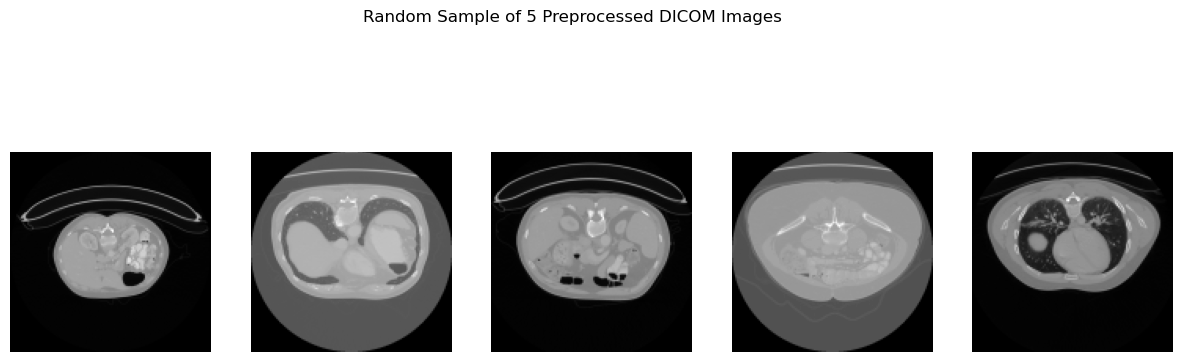

In [9]:
import os
import pydicom
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

# -----------------------------
# Load and Preprocess DICOM Images (No CT Windowing)
# -----------------------------
def load_dicom_images(base_path, img_size=(128, 128)):
    image_list = []
    skipped_files = 0

    for root, _, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(".dcm"):
                dicom_path = os.path.join(root, file)
                try:
                    dicom_data = pydicom.dcmread(dicom_path)
                    if "PixelData" not in dicom_data:
                        skipped_files += 1
                        continue

                    raw_img = dicom_data.pixel_array.astype(np.float32)

                    # Normalize using full image range
                    min_val = np.min(raw_img)
                    max_val = np.max(raw_img)
                    norm_img = (raw_img - min_val) / (max_val - min_val + 1e-5)  # [0, 1]

                    # Resize
                    resized_img = cv2.resize(norm_img, img_size, interpolation=cv2.INTER_AREA)

                    # Expand for channel
                    img_array = np.expand_dims(resized_img, axis=-1)

                    image_list.append(img_array)

                except Exception as e:
                    print(f"❌ Error reading {dicom_path}: {e}")
                    skipped_files += 1

    if not image_list:
        raise ValueError("⚠️ No valid DICOM images found!")

    # Convert and normalize for GANs
    image_data = np.array(image_list)
    image_data = (image_data - 0.5) * 2  # Normalize to [-1, 1]

    print(f"✅ Loaded {image_data.shape[0]} images of shape {image_data.shape[1:]}")
    if skipped_files:
        print(f"⚠️ Skipped {skipped_files} files (invalid or no pixel data)")

    return image_data

# -----------------------------
# Visualization Function
# -----------------------------
def show_sample_images(image_data, num_samples=5):
    indices = random.sample(range(len(image_data)), num_samples)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, idx in enumerate(indices):
        axes[i].imshow(((image_data[idx].squeeze() + 1) / 2), cmap="gray")
        axes[i].axis("off")
    plt.suptitle(f"Random Sample of {num_samples} Preprocessed DICOM Images")
    plt.show()

# -----------------------------
# Run the Loader
# -----------------------------
dicom_path = r"C:\ct data set\Pancreas-CT data\Pancreas-CT"
image_data = load_dicom_images(dicom_path)
show_sample_images(image_data)


In [11]:
import os
import pydicom
import numpy as np
import cv2
from tqdm import tqdm

# Define paths
base_path = r"C:\ct data set\Pancreas-CT data\Pancreas-CT"
output_dir = r"C:\ct data set\Pancreas-CT data\Numpy_data"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Collect all DICOM file paths
dicom_files = [os.path.join(root, file)
               for root, _, files in os.walk(base_path)
               for file in files if file.lower().endswith(".dcm")]

if not dicom_files:
    print("❌ No DICOM files found.")
    exit()

total_files = len(dicom_files)
print(f"📂 Found {total_files} DICOM files. Checking pixel data format...")

# Tracking statistics
processed_count = 0
missing_pixel_data = 0
unsupported_format = 0
corrupt_files = []

# Function to process and save DICOM files
def process_dicom_to_numpy(dicom_path, output_dir, index):
    global missing_pixel_data, unsupported_format, processed_count

    try:
        # Read DICOM file safely
        with pydicom.dcmread(dicom_path, force=True) as dicom_data:

            # Check pixel data presence
            if "PixelData" not in dicom_data:
                missing_pixel_data += 1
                return False

            # Extract pixel array safely
            try:
                img_array = dicom_data.pixel_array.astype(np.float32)
            except Exception:
                unsupported_format += 1
                return False

            # Convert RGB to grayscale if necessary
            if len(img_array.shape) == 3 and img_array.shape[-1] == 3:
                img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)

            # Normalize pixel values to [0,1]
            img_array -= np.min(img_array)  # Shift minimum to 0
            img_array /= np.max(img_array) if np.max(img_array) > 0 else 1

            # Resize to (128x128) for model training
            img_array = cv2.resize(img_array, (128, 128), interpolation=cv2.INTER_AREA)

            # Save as NumPy array
            npy_filename = os.path.join(output_dir, f"image_{index:05d}.npy")
            np.save(npy_filename, img_array)

            processed_count += 1
            return True

    except Exception:
        corrupt_files.append(dicom_path)
        return False

# ✅ Moved this part to AFTER dicom_files is defined
for idx, dicom_path in tqdm(enumerate(dicom_files), total=len(dicom_files), desc="🌀 Processing DICOMs"):
    process_dicom_to_numpy(dicom_path, output_dir, idx)

# Verify output
saved_files = len(os.listdir(output_dir))
file_sizes = [os.path.getsize(os.path.join(output_dir, f)) for f in os.listdir(output_dir)]

print("\n🎉 Processing Complete!")
print(f"✅ Successfully converted: {processed_count}/{total_files} files.")
print(f"⚠️ Missing pixel data: {missing_pixel_data} files.")
print(f"🛑 Unsupported formats: {unsupported_format} files.")
print(f"❌ Corrupt/unreadable files: {len(corrupt_files)}.")
print(f"📁 NumPy files in output folder: {saved_files}")
print(f"📏 Avg NumPy file size: {np.mean(file_sizes) / 1024:.2f} KB")

if saved_files != processed_count:
    print("⚠️ WARNING: Some files might not have been saved properly!")

if corrupt_files:
    print("\n🛑 Sample corrupt files:")
    for file in corrupt_files[:5]:
        print(file)


📂 Found 18942 DICOM files. Checking pixel data format...


🌀 Processing DICOMs: 100%|██████████| 18942/18942 [02:16<00:00, 138.73it/s]



🎉 Processing Complete!
✅ Successfully converted: 18942/18942 files.
⚠️ Missing pixel data: 0 files.
🛑 Unsupported formats: 0 files.
❌ Corrupt/unreadable files: 0.
📁 NumPy files in output folder: 18942
📏 Avg NumPy file size: 64.12 KB


In [13]:
import os
import numpy as np
import sys
from sklearn.model_selection import train_test_split
import shutil
from tqdm import tqdm
import glob

# ======================= CONFIG =======================
npy_dir = r"C:\\ct data set\\Pancreas-CT data\\Numpy_data"
split_dir = r"C:\ct data set\Pancreas-CT data\Split_Data"

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Validate split ratios
assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1.0"

train_dir = os.path.join(split_dir, "train")
val_dir = os.path.join(split_dir, "val")
test_dir = os.path.join(split_dir, "test")

# ================ CLEAN OUTPUT FOLDERS ================
for dir in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir):
        shutil.rmtree(dir)
    os.makedirs(dir, exist_ok=True)

# ================ GATHER .NPY FILES ===================
print(f"🔍 Searching for .npy files in: {npy_dir}")
npy_files = glob.glob(os.path.join(npy_dir, '**', '*.npy'), recursive=True)

if len(npy_files) == 0:
    print(f"⚠️ Warning: No .npy files found in: {npy_dir}")
    sys.exit(1)

print(f"✅ Found {len(npy_files)} .npy files")

# ================ SPLIT FILES =========================
train_files, test_val_files = train_test_split(npy_files, test_size=(1 - train_ratio), random_state=42, shuffle=True)
val_files, test_files = train_test_split(test_val_files, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42, shuffle=True)

# ================ MOVE FILES ==========================
def move_files(file_list, dest_dir, move=True):
    operation = shutil.move if move else shutil.copy2
    for file_path in tqdm(file_list, desc=f"📂 Processing {os.path.basename(dest_dir)}", unit="file"):
        # Handle duplicate names by adding subfolder prefix
        base_name = os.path.basename(file_path)
        prefix = os.path.basename(os.path.dirname(file_path))
        new_name = f"{prefix}_{base_name}"
        dest_path = os.path.join(dest_dir, new_name)

        if not os.path.exists(dest_path):
            operation(file_path, dest_path)

# Move files
move_files(train_files, train_dir, move=True)
move_files(val_files, val_dir, move=True)
move_files(test_files, test_dir, move=True)

# ================ SUMMARY =============================
print("\n✅ Dataset split complete!")
print(f"📁 Train: {len(train_files)} files ({train_ratio*100:.1f}%)")
print(f"📁 Validation: {len(val_files)} files ({val_ratio*100:.1f}%)")
print(f"📁 Test: {len(test_files)} files ({test_ratio*100:.1f}%)")


🔍 Searching for .npy files in: C:\\ct data set\\Pancreas-CT data\\Numpy_data
✅ Found 18942 .npy files


📂 Processing test: 100%|██████████| 2842/2842 [00:01<00:00, 2215.14file/s]


✅ Dataset split complete!
📁 Train: 13259 files (70.0%)
📁 Validation: 2841 files (15.0%)
📁 Test: 2842 files (15.0%)


In [15]:
import os
import numpy as np
from tqdm import tqdm
import glob

# Path to training .npy files
train_npy_dir = r"C:\ct data set\Pancreas-CT data\Split_Data\train"

# Load all .npy files from train
train_files = sorted(glob.glob(os.path.join(train_npy_dir, "*.npy")))
print(f"📁 Found {len(train_files)} training files")

# Load images
train_images = []
for path in tqdm(train_files, desc="📥 Loading Train Images"):
    img = np.load(path)
    train_images.append(img)
 
# Expand dims for CNN input: (N, 128, 128, 1)
train_images = np.expand_dims(np.array(train_images), axis=-1)
print(f"✅ Loaded training image shape: {train_images.shape}")


📁 Found 13259 training files


📥 Loading Train Images: 100%|██████████| 13259/13259 [00:08<00:00, 1512.08it/s]


✅ Loaded training image shape: (13259, 128, 128, 1)


In [17]:
# Convert grayscale (128x128x1) to 3-channel (128x128x3)
train_images_rgb = np.repeat(train_images, 3, axis=-1)

# Now the shape will be (128, 128, 3), which is compatible with ConvNeXt
print(f"Shape after conversion: {train_images_rgb.shape}")

Shape after conversion: (13259, 128, 128, 3)


In [19]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

# Convert grayscale (128x128x1) to 3-channel (128x128x3)
train_images_rgb = np.repeat(train_images, 3, axis=-1)

# Resize to MobileNetV2 input size (160x160)
train_images_resized = tf.image.resize(train_images_rgb, (160, 160)).numpy()

# Preprocess for MobileNetV2
train_images_preprocessed = preprocess_input(train_images_resized)

# Load MobileNetV2 (without top classifier)
base_model = MobileNetV2(input_shape=(160, 160, 3), include_top=False, weights='imagenet', pooling='avg')
base_model.trainable = False

# Extract features
features = base_model.predict(train_images_preprocessed, batch_size=64, verbose=1)
print(f"✅ Feature shape: {features.shape}")  # Should be (N, 1280)


208/208 ━━━━━━━━━━━━━━━━━━━━ 150s 689ms/step
✅ Feature shape: (13259, 1280)


In [21]:
from sklearn.cluster import KMeans
import numpy as np

# Perform clustering on extracted features
n_clusters = 2  # cancer / no cancer
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
pseudo_labels = kmeans.fit_predict(features)

print(f"✅ Clustering complete. Labels distribution: {np.bincount(pseudo_labels)}")


✅ Clustering complete. Labels distribution: [9456 3803]


In [23]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# Output folder to save clustered images
output_root = r"C:\ct data set\Pancreas-CT data\Clustered_Images"
os.makedirs(output_root, exist_ok=True)

# Create subfolders for each cluster
for cluster_id in np.unique(pseudo_labels):
    os.makedirs(os.path.join(output_root, f"cluster_{cluster_id}"), exist_ok=True)

# Save images into the respective cluster folders
for i, img_array in tqdm(enumerate(train_images[..., 0]), total=len(train_images), desc="📸 Saving clustered images"):
    cluster_id = pseudo_labels[i]
    save_path = os.path.join(output_root, f"cluster_{cluster_id}", f"image_{i:05d}.png")
    plt.imsave(save_path, img_array, cmap='gray')


📸 Saving clustered images: 100%|██████████| 13259/13259 [01:10<00:00, 188.13it/s]


In [25]:
from sklearn.metrics import silhouette_score
score = silhouette_score(features, pseudo_labels)
print(f"Silhouette Score: {score}")


Silhouette Score: 0.29066362977027893


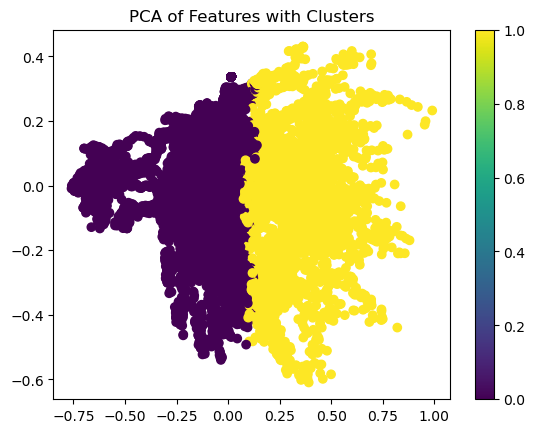

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=pseudo_labels, cmap='viridis')
plt.colorbar()
plt.title("PCA of Features with Clusters")
plt.show()


In [29]:
# Mapping cluster ID to pseudo-label (can swap if needed)
cluster_to_label = {0: 0, 1: 1}

# Convert cluster IDs to pseudo-labels
final_labels = np.array([cluster_to_label[c] for c in pseudo_labels])

print(f"✅ Final label shape: {final_labels.shape}")
print(f"🧪 Label distribution: {np.bincount(final_labels)}")


✅ Final label shape: (13259,)
🧪 Label distribution: [9456 3803]


In [31]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(final_labels), y=final_labels)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")


Class weights: {0: 0.701089255499154, 1: 1.7432290297133841}


Image size: (128, 128)
Image mode (color format): RGB


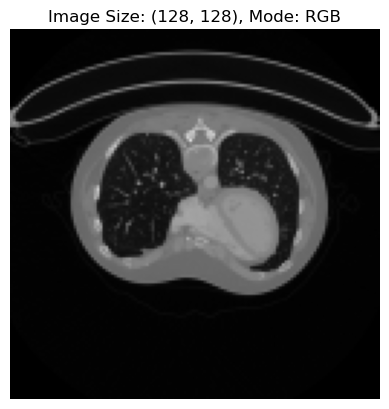

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Assuming 'train_images_rgb' is a numpy array with shape (N, 128, 128, 3)
# Let's visualize the first image to check its properties

# Convert numpy array to PIL Image for better inspection
image = Image.fromarray((train_images_rgb[0] * 255).astype(np.uint8))

# Check the image size and mode (RGB, Grayscale, etc.)
image_size = image.size  # (width, height)
image_mode = image.mode  # 'RGB' or 'L' for grayscale, etc.

print(f"Image size: {image_size}")  # Prints: (width, height)
print(f"Image mode (color format): {image_mode}")  # Prints: 'RGB'

# Show the image
plt.imshow(train_images_rgb[0])  # Assuming this is RGB
plt.title(f"Image Size: {image_size}, Mode: {image_mode}")
plt.axis('off')  # Hide axes
plt.show()


Found 13259 images belonging to 2 classes.



Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_pres… │ (None, 160, 160,  │          0 │ input_layer[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stem  │ (None, 40, 40,    │      4,896 │ convnext_tiny_pr… │
│ (Sequential)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │      4,800 │ convnext_tiny_st… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │        192 │ convnext_tiny_st… │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │     37,248 │ convnext_tiny_st… │
│ (Dense)             │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │     36,960 │ convnext_tiny_st… │
│ (Dense)             │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │         96 │ convnext_tiny_st… │
│ (LayerScale)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 40, 40,    │          0 │ convnext_tiny_st… │
│                     │ 96)               │            │ convnext_tiny_st… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │      4,800 │ add[0][0]         │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │        192 │ convnext_tiny_st… │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │     37,248 │ convnext_tiny_st… │
│ (Dense)             │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │     36,960 │ convnext_tiny_st… │
│ (Dense)             │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │         96 │ convnext_tiny_st

 Total params: 28,214,369 (107.63 MB)

 Trainable params: 394,241 (1.50 MB)

 Non-trainable params: 27,820,128 (106.13 MB)

C:\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 2583s 6s/step - accuracy: 0.5824 - loss: 6.7684
Epoch 2/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 2524s 6s/step - accuracy: 0.7163 - loss: 5.7635
Epoch 3/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 2552s 6s/step - accuracy: 0.7682 - loss: 5.0020
Epoch 4/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 2526s 6s/step - accuracy: 0.8073 - loss: 4.3481
Epoch 5/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 2534s 6s/step - accuracy: 0.8243 - loss: 3.7794
Epoch 6/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 2527s 6s/step - accuracy: 0.8333 - loss: 3.3053
Epoch 7/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 2632s 6s/step - accuracy: 0.8505 - loss: 2.8832
Epoch 8/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 2526s 6s/step - accuracy: 0.8632 - loss: 2.4942
Epoch 9/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 2518s 6s/step - accuracy: 0.8689 - loss: 2.1804
Epoch 10/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 2394s 6s/step - accuracy: 0.8714 - loss: 1.9174


✅ Model saved at C:\ct data set\Pancreas-CT data\New_Model_Folder\pancreatic_cancer_model.h5


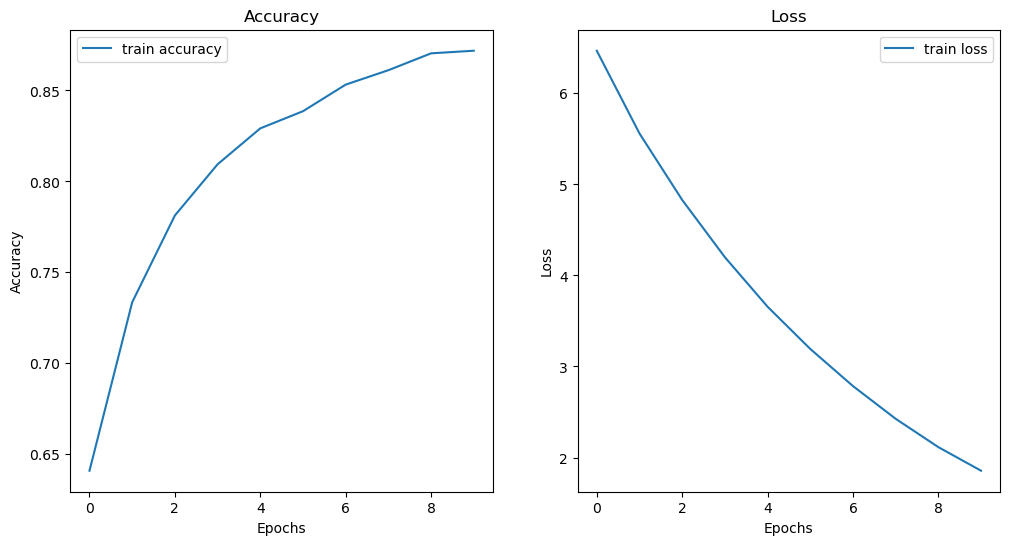

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

# ==================== CONFIG ========================
IMG_SIZE = 160  # ConvNeXt requires 160x160 input size
BATCH_SIZE = 32
EPOCHS = 10  # Reduce the number of epochs for controlled learning
LEARNING_RATE = 1e-5  # Lower learning rate to slow down the convergence
NUM_CLASSES = 1  # Binary classification (Cancer or No Cancer)

# Define paths
train_images_dir = r"C:\ct data set\Pancreas-CT data\Clustered_Images"  # Path to your training images
output_model_dir = r"C:\ct data set\Pancreas-CT data\New_Model_Folder"  # Updated path to save the trained model

# ==================== Load Training Data =======================
# Instead of loading all images into memory, use ImageDataGenerator for dynamic loading and resizing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize the images to [0, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=lambda x: tf.image.resize(x, (IMG_SIZE, IMG_SIZE))  # Resize dynamically
)

# Create ImageDataGenerator for training data
train_generator = train_datagen.flow_from_directory(
    train_images_dir,  # Replace with actual directory where the images are stored
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to (160, 160)
    batch_size=BATCH_SIZE,
    class_mode='binary',  # For binary classification
    shuffle=True
)

# ==================== Load ConvNeXt Tiny ========================
base_model = ConvNeXtTiny(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

# Freeze the ConvNeXt layers initially
base_model.trainable = False

# ==================== Build Classifier ========================
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global pooling to reduce dimensionality
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)  # L2 regularization
x = Dropout(0.7)(x)  # Increased dropout to prevent overfitting
x = Dense(NUM_CLASSES, activation='sigmoid')(x)  # Sigmoid for binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# ==================== Compile the Model ========================
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

# Show the model summary
model.summary()

# ==================== Train the Model ========================
history = model.fit(
    train_generator,
    epochs=EPOCHS
)

# ==================== Save the Trained Model ========================
# Ensure the output directory exists
os.makedirs(output_model_dir, exist_ok=True)

# Save the model in the new output directory
model_save_path = os.path.join(output_model_dir, 'pancreatic_cancer_model.h5')
model.save(model_save_path)

print(f"✅ Model saved at {model_save_path}")

# ==================== Plot Training and Validation Accuracy/Loss ========================
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [3]:
from tensorflow import keras

model = keras.models.load_model(r'C:\ct data set\Pancreas-CT data\New_Model_Folder\pancreatic_cancer_model.keras')



C:\anaconda\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [9]:
# Load the model from .keras format
loaded_model = tf.keras.models.load_model(model_save_path_keras)

# Check if the model loaded correctly
loaded_model.summary()


C:\anaconda\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_pres… │ (None, 160, 160,  │          0 │ input_layer[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stem  │ (None, 40, 40,    │      4,896 │ convnext_tiny_pr… │
│ (Sequential)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │      4,800 │ convnext_tiny_st… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │        192 │ convnext_tiny_st… │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │     37,248 │ convnext_tiny_st… │
│ (Dense)             │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │     36,960 │ convnext_tiny_st… │
│ (Dense)             │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │         96 │ convnext_tiny_st… │
│ (LayerScale)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 40, 40,    │          0 │ convnext_tiny_st… │
│                     │ 96)               │            │ convnext_tiny_st… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │      4,800 │ add[0][0]         │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │        192 │ convnext_tiny_st… │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │     37,248 │ convnext_tiny_st… │
│ (Dense)             │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │     36,960 │ convnext_tiny_st… │
│ (Dense)             │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │         96 │ convnext_tiny_st

 Total params: 28,608,612 (109.13 MB)

 Trainable params: 394,241 (1.50 MB)

 Non-trainable params: 27,820,128 (106.13 MB)

 Optimizer params: 394,243 (1.50 MB)

In [11]:
import os
import numpy as np
from tqdm import tqdm
import glob

# Path to validation .npy files
val_npy_dir = r"C:\ct data set\Pancreas-CT data\Split_Data\val"

# Load all .npy files from val
val_files = sorted(glob.glob(os.path.join(val_npy_dir, "*.npy")))
print(f"📁 Found {len(val_files)} validation files")

# Load validation images
val_images = []
for path in tqdm(val_files, desc="📥 Loading Validation Images"):
    img = np.load(path)
    val_images.append(img)

# Expand dims for CNN input: (N, 128, 128, 1)
val_images = np.expand_dims(np.array(val_images), axis=-1)
print(f"✅ Loaded validation image shape: {val_images.shape}")


📁 Found 2841 validation files


📥 Loading Validation Images: 100%|██████████| 2841/2841 [00:09<00:00, 304.87it/s]


✅ Loaded validation image shape: (2841, 128, 128, 1)


In [12]:
import os
import numpy as np
from tqdm import tqdm
import glob

# Path to validation .npy files
val_npy_dir = r"C:\ct data set\Pancreas-CT data\Split_Data\val"

# Load all .npy files from val
val_files = sorted(glob.glob(os.path.join(val_npy_dir, "*.npy")))
print(f"📁 Found {len(val_files)} validation files")

# Load validation images
val_images = []
for path in tqdm(val_files, desc="📥 Loading Validation Images"):
    img = np.load(path)
    val_images.append(img)

# Expand dims for CNN input: (N, 128, 128, 1)
val_images = np.expand_dims(np.array(val_images), axis=-1)
print(f"✅ Loaded validation image shape: {val_images.shape}")

# Convert grayscale (128x128x1) to 3-channel (128x128x3)
val_images_rgb = np.repeat(val_images, 3, axis=-1)
print(f"🎨 Shape after conversion to RGB: {val_images_rgb.shape}")


📁 Found 2841 validation files


📥 Loading Validation Images: 100%|██████████| 2841/2841 [00:00<00:00, 4012.60it/s]


✅ Loaded validation image shape: (2841, 128, 128, 1)
🎨 Shape after conversion to RGB: (2841, 128, 128, 3)


In [15]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

# Convert grayscale (128x128x1) to 3-channel (128x128x3)
val_images_rgb = np.repeat(val_images, 3, axis=-1)

# Resize to MobileNetV2 input size (160x160)
val_images_resized = tf.image.resize(val_images_rgb, (160, 160)).numpy()

# Preprocess for MobileNetV2
val_images_preprocessed = preprocess_input(val_images_resized)

# Load MobileNetV2 (without top classifier)
base_model = MobileNetV2(input_shape=(160, 160, 3), include_top=False, weights='imagenet', pooling='avg')
base_model.trainable = False

# Extract features
val_features = base_model.predict(val_images_preprocessed, batch_size=64, verbose=1)
print(f"✅ Validation feature shape: {val_features.shape}")  # Should be (N, 1280)


45/45 ━━━━━━━━━━━━━━━━━━━━ 32s 667ms/step
✅ Validation feature shape: (2841, 1280)


In [17]:
from sklearn.cluster import KMeans
import numpy as np

# Perform clustering on extracted validation features
n_clusters = 2  # cancer / no cancer
kmeans_val = KMeans(n_clusters=n_clusters, random_state=42)
val_pseudo_labels = kmeans_val.fit_predict(val_features)

print(f"✅ Validation clustering complete. Labels distribution: {np.bincount(val_pseudo_labels)}")


✅ Validation clustering complete. Labels distribution: [2030  811]


In [19]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Output folder to save clustered validation images
val_output_root = r"C:\ct data set\Pancreas-CT data\Clustered_Val_Images"
os.makedirs(val_output_root, exist_ok=True)

# Create subfolders for each cluster
for cluster_id in np.unique(val_pseudo_labels):
    os.makedirs(os.path.join(val_output_root, f"cluster_{cluster_id}"), exist_ok=True)

# Save validation images into their respective cluster folders
for i, img_array in tqdm(enumerate(val_images[..., 0]), total=len(val_images), desc="📸 Saving clustered validation images"):
    cluster_id = val_pseudo_labels[i]
    save_path = os.path.join(val_output_root, f"cluster_{cluster_id}", f"image_{i:05d}.png")
    plt.imsave(save_path, img_array, cmap='gray')


📸 Saving clustered validation images: 100%|██████████| 2841/2841 [00:15<00:00, 180.15it/s]


In [21]:
# ==================== Setup Validation Data Generator ========================
val_datagen = ImageDataGenerator(rescale=1./255)  # Rescale the images to [0, 1]

# Replace with your validation data directory
val_directory = r"C:\ct data set\Pancreas-CT data\Clustered_Val_Images"

# Create ImageDataGenerator for validation data
val_generator = val_datagen.flow_from_directory(
    val_directory,  # Path to validation images directory
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to (160, 160)
    batch_size=BATCH_SIZE,
    class_mode='binary',  # For binary classification
    shuffle=False  # Don't shuffle for evaluation
)

# ==================== Evaluate the Model ========================
val_loss, val_accuracy = model.evaluate(val_generator)

# Output the validation results
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")


Found 2841 images belonging to 2 classes.


C:\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 578s 6s/step - accuracy: 0.9203 - loss: 1.6982
Validation Accuracy: 90.85%
Validation Loss: 1.6866


In [1]:
import numpy as np
import tensorflow as tf
from scipy.optimize import minimize

# --- Load your trained model ---
model_path = r'C:\ct data set\Pancreas-CT data\New_Model_Folder\pancreatic_cancer_model.keras'
model = tf.keras.models.load_model(model_path)

# --- Prepare your validation data generator exactly as before ---
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 160
BATCH_SIZE = 32

val_datagen = ImageDataGenerator(rescale=1./255)
val_directory = r"C:\ct data set\Pancreas-CT data\Clustered_Val_Images"

val_generator = val_datagen.flow_from_directory(
    val_directory,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# --- Get predicted probabilities on validation set ---
val_preds = model.predict(val_generator, verbose=1)

# --- Convert probabilities to logits for temperature scaling ---
# Add small epsilon to avoid log(0)
eps = 1e-12
logits = np.log(val_preds / (1 - val_preds + eps) + eps)

# --- True labels from validation generator (since shuffle=False) ---
true_labels = val_generator.classes

# --- Define the temperature scaling loss function ---
def temperature_loss(temp):
    temp = temp[0]
    scaled_logits = logits / temp
    scaled_probs = 1 / (1 + np.exp(-scaled_logits))
    loss = -np.mean(
        true_labels * np.log(scaled_probs + eps) +
        (1 - true_labels) * np.log(1 - scaled_probs + eps)
    )
    return loss

# --- Optimize temperature parameter ---
res = minimize(temperature_loss, x0=[1.0], bounds=[(0.05, 10.0)])
optimal_temp = res.x[0]
print(f"✅ Optimal temperature: {optimal_temp:.4f}")

# --- Apply temperature scaling ---
scaled_logits = logits / optimal_temp
calibrated_probs = 1 / (1 + np.exp(-scaled_logits))

# --- Calculate new calibrated loss ---
calibrated_loss = -np.mean(
    true_labels * np.log(calibrated_probs + eps) +
    (1 - true_labels) * np.log(1 - calibrated_probs + eps)
)
print(f"✅ Calibrated loss: {calibrated_loss:.4f}")

# --- Calculate accuracy with calibrated probabilities (threshold 0.5) ---
calibrated_preds = (calibrated_probs >= 0.5).astype(int)
accuracy = np.mean(calibrated_preds == true_labels)
print(f"✅ Accuracy after calibration: {accuracy * 100:.2f}%")


C:\anaconda\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Found 2841 images belonging to 2 classes.


C:\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 500s 6s/step
✅ Optimal temperature: 1.0000
✅ Calibrated loss: 1.0492
✅ Accuracy after calibration: 57.94%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


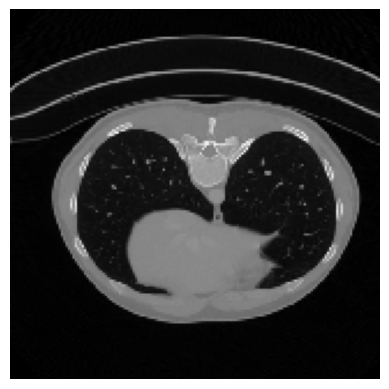

Prediction: Cancer (Probability: 0.93)


In [26]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
model_path = r"C:\ct data set\Pancreas-CT data\New_Model_Folder\pancreatic_cancer_model.keras"
model = tf.keras.models.load_model(model_path)

# Function to preprocess the image and make predictions
def predict_image(img_path):
    # Check if the file exists
    if not os.path.exists(img_path):
        print(f"Error: The image at {img_path} does not exist.")
        return

    # Load the image (the image could be in PNG format, Keras will handle it)
    img = image.load_img(img_path, target_size=(160, 160))  # Resize the image to the size the model expects

    # Convert the image to a numpy array
    img_array = image.img_to_array(img)

    # Expand the dimensions to match the model's input shape (batch_size, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)

    # Normalize the image to [0, 1]
    img_array /= 255.0

    # Predict the class (output will be between 0 and 1 for binary classification)
    prediction = model.predict(img_array)

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

    # Interpretation of prediction
    if prediction[0] > 0.5:  # If the predicted probability is > 0.5, we classify it as "cancer"
        print(f"Prediction: Cancer (Probability: {prediction[0][0]:.2f})")
    else:
        print(f"Prediction: No Cancer (Probability: {1 - prediction[0][0]:.2f})")

# Example usage
img_path = r"C:\pancreatic CT\DATASET\test\test\normal\1-016.jpg"  # PNG image path
predict_image(img_path)


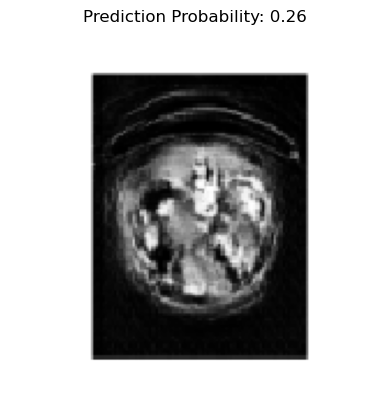

🟢 Prediction: No Cancer Detected (Confidence: 73.98%)


In [11]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# ====================== Load the Trained Model ======================
model_path = r"C:\ct data set\Pancreas-CT data\model_output\pancreatic_cancer_model.keras"
model = tf.keras.models.load_model(model_path)

# ====================== Pre-compiled Prediction Function ======================
@tf.function(reduce_retracing=True)
def model_predict(img_array):
    return model(img_array, training=False)

# ====================== Prediction Function ======================
def predict_image(img_path):
    # Check if the file exists
    if not os.path.exists(img_path):
        print(f"❌ Error: The image at {img_path} does not exist.")
        return

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(160, 160))  # Resize
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # (1, 160, 160, 3)
    img_array = img_array / 255.0  # Normalize to [0,1]

    # Predict
    preds = model_predict(img_array)
    probability = preds.numpy()[0][0]

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction Probability: {probability:.2f}")
    plt.show()

    # Interpretation
    if probability > 0.5:
        print(f"🔵 Prediction: Cancer Detected (Confidence: {probability*100:.2f}%)")
    else:
        print(f"🟢 Prediction: No Cancer Detected (Confidence: {(1 - probability)*100:.2f}%)")

# ====================== Example Usage ======================
img_path = r"C:\ct data set\Pancreas-CT data\Merged_Clustered_Images\cluster_0\gan_image_00010.png"# Your image path
predict_image(img_path)


✅ Model loaded successfully!
Found 2841 images belonging to 2 classes.


C:\anaconda\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 496s 6s/step

🔵 Precision: 0.8078
🟢 Recall: 0.8915
⚖️ F1-Score: 0.8476

📊 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.95      0.92      0.93      2030
     Class 1       0.81      0.89      0.85       811

    accuracy                           0.91      2841
   macro avg       0.88      0.90      0.89      2841
weighted avg       0.91      0.91      0.91      2841



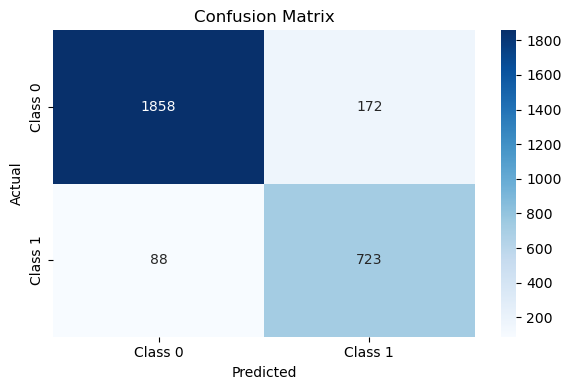

In [30]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# ==================== Configuration ====================
IMG_SIZE = 160
BATCH_SIZE = 32

# ==================== Load Trained Model ====================
model_path = r"C:\ct data set\Pancreas-CT data\New_Model_Folder\pancreatic_cancer_model.keras"
model = tf.keras.models.load_model(model_path)
print("✅ Model loaded successfully!")

# ==================== Setup Validation Data ====================
val_directory = r"C:\ct data set\Pancreas-CT data\Clustered_Val_Images"

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_directory,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# ==================== Prediction ====================
y_pred_probs = model.predict(val_generator, verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = val_generator.classes

# ==================== Metrics ====================
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(f"\n🔵 Precision: {precision:.4f}")
print(f"🟢 Recall: {recall:.4f}")
print(f"⚖️ F1-Score: {f1:.4f}")
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Class 0", "Class 1"]))

# ==================== Confusion Matrix Plot ====================
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


Found 2841 images belonging to 2 classes.
89/89 ━━━━━━━━━━━━━━━━━━━━ 546s 6s/step - accuracy: 0.9203 - loss: 1.6982
Validation Accuracy: 90.85%
Validation Loss: 1.6866


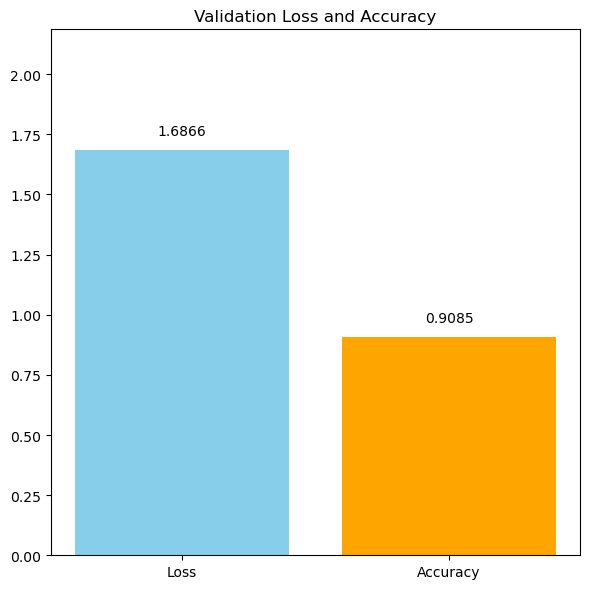

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# ==================== Constants ========================
IMG_SIZE = 160
BATCH_SIZE = 32

# ==================== Setup Validation Data Generator ========================
val_datagen = ImageDataGenerator(rescale=1./255)

val_directory = r"C:\ct data set\Pancreas-CT data\Clustered_Val_Images"

val_generator = val_datagen.flow_from_directory(
    val_directory,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# ==================== Evaluate the Model ========================
val_loss, val_accuracy = model.evaluate(val_generator)

print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

# ==================== Plot Bar Graph ========================
plt.figure(figsize=(6, 6))
metrics = ['Loss', 'Accuracy']
values = [val_loss, val_accuracy]

bars = plt.bar(metrics, values, color=['skyblue', 'orange'])

# Set y-axis limit dynamically
plt.ylim(0, max(values) + 0.5)
plt.title('Validation Loss and Accuracy')

# Label each bar
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 0.05, f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

# Configuration
IMG_SIZE = 160
BATCH_SIZE = 32
EPOCHS = 15  # Increased for fine-tuning
LEARNING_RATE = 1e-5  # Start with a small LR, will be adjusted later
NUM_CLASSES = 1  # Binary classification (cancer / no cancer)


In [3]:
# Use rescale=1./255 for both train and validation for ConvNeXt input consistency
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Paths to your folders
train_images_dir = r"C:\ct data set\Pancreas-CT data\Clustered_Images"
val_images_dir = r"C:\ct data set\Pancreas-CT data\Clustered_Val_Images"

train_generator = train_datagen.flow_from_directory(
    train_images_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_images_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


NameError: name 'ImageDataGenerator' is not defined

In [7]:
# Compute class weights from training labels to reduce loss spikes due to imbalance
train_labels = train_generator.classes
class_weights_arr = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights_arr))
print(f"Class weights: {class_weights}")


Class weights: {0: 0.701089255499154, 1: 1.7432290297133841}


In [9]:
base_model = ConvNeXtTiny(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze initially

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)  # Reduced L2
x = Dropout(0.4)(x)  # Reduced dropout
x = Dense(NUM_CLASSES, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_pres… │ (None, 160, 160,  │          0 │ input_layer[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stem  │ (None, 40, 40,    │      4,896 │ convnext_tiny_pr… │
│ (Sequential)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │      4,800 │ convnext_tiny_st… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │        192 │ convnext_tiny_st… │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │     37,248 │ convnext_tiny_st… │
│ (Dense)             │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │     36,960 │ convnext_tiny_st… │
│ (Dense)             │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │         96 │ convnext_tiny_st… │
│ (LayerScale)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 40, 40,    │          0 │ convnext_tiny_st… │
│                     │ 96)               │            │ convnext_tiny_st… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │      4,800 │ add[0][0]         │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │        192 │ convnext_tiny_st… │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │     37,248 │ convnext_tiny_st… │
│ (Dense)             │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │     36,960 │ convnext_tiny_st… │
│ (Dense)             │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │         96 │ convnext_tiny_st

 Total params: 28,214,369 (107.63 MB)

 Trainable params: 394,241 (1.50 MB)

 Non-trainable params: 27,820,128 (106.13 MB)

Found 13259 images belonging to 2 classes.


C:\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6826 - loss: 6.5476
Epoch 1: loss improved from inf to 6.28430, saving model to C:\ct data set\Pancreas-CT data\New_Model_Folder\pancreatic_cancer_model_10epoch.keras
415/415 ━━━━━━━━━━━━━━━━━━━━ 2468s 6s/step - accuracy: 0.6827 - loss: 6.5470 - learning_rate: 1.0000e-05
Epoch 2/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7760 - loss: 5.5852
Epoch 2: loss improved from 6.28430 to 5.38139, saving model to C:\ct data set\Pancreas-CT data\New_Model_Folder\pancreatic_cancer_model_10epoch.keras
415/415 ━━━━━━━━━━━━━━━━━━━━ 2553s 6s/step - accuracy: 0.7760 - loss: 5.5847 - learning_rate: 1.0000e-05
Epoch 3/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8150 - loss: 4.8061
Epoch 3: loss improved from 5.38139 to 4.63196, saving model to C:\ct data set\Pancreas-CT data\New_Model_Folder\pancreatic_cancer_model_10epoch.keras
415/415 ━━━━━━━━━━━━━━━━━━━━ 2477s 6s/step - accuracy: 0.8150 - loss: 4.8057 - learnin

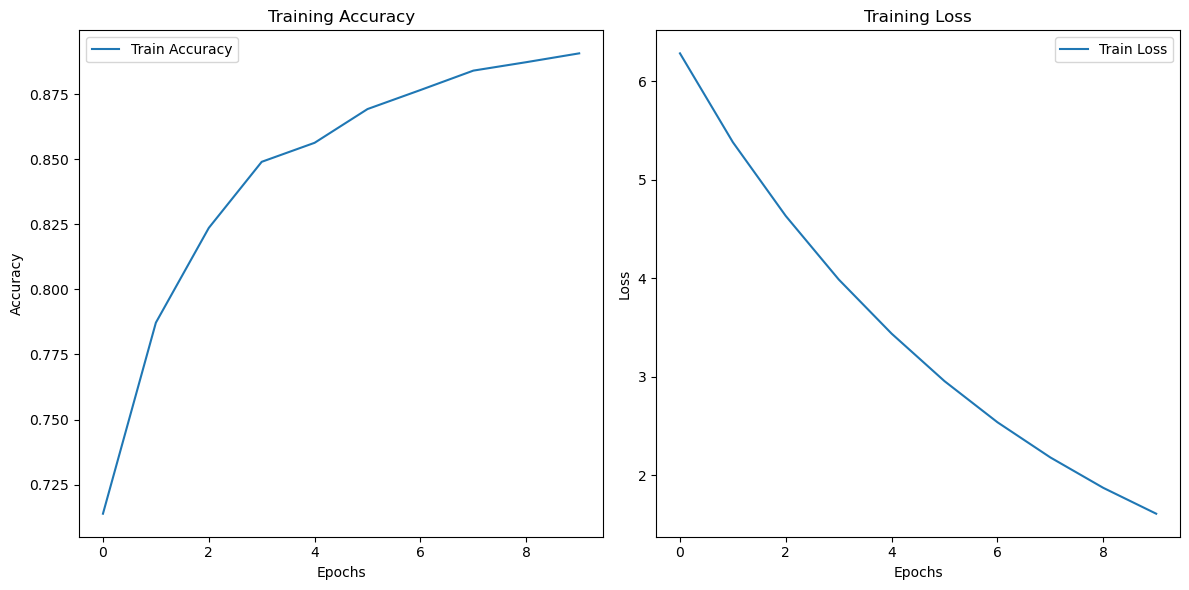

✅ Model training complete and saved at: C:\ct data set\Pancreas-CT data\New_Model_Folder\pancreatic_cancer_model_10epoch.keras


In [3]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

# ==================== CONFIG ====================
IMG_SIZE = 160
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-5
NUM_CLASSES = 1

# ==================== PATHS ====================
train_images_dir = r"C:\ct data set\Pancreas-CT data\Clustered_Images"
output_model_dir = r"C:\ct data set\Pancreas-CT data\New_Model_Folder"
model_save_path = os.path.join(output_model_dir, 'pancreatic_cancer_model_10epoch.keras')
os.makedirs(output_model_dir, exist_ok=True)

# ==================== Data Generators ====================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=lambda x: tf.image.resize(x, (IMG_SIZE, IMG_SIZE))
)

train_generator = train_datagen.flow_from_directory(
    train_images_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

# ==================== Model Definition ====================
base_model = ConvNeXtTiny(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ==================== Callbacks ====================
callbacks = [
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2, verbose=1),
    ModelCheckpoint(model_save_path, monitor='loss', save_best_only=True, verbose=1)
]

# ==================== Training ====================
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

# ==================== Plot Training Results ====================
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.tight_layout()
plt.show()

print(f"✅ Model training complete and saved at: {model_save_path}")


In [7]:
from tensorflow import keras

model01 = keras.models.load_model(r'C:\ct data set\Pancreas-CT data\New_Model_Folder\pancreatic_cancer_model_10epoch.keras')



In [9]:
# ==================== Setup Validation Data Generator ========================
val_datagen = ImageDataGenerator(rescale=1./255)  # Rescale the images to [0, 1]

# Replace with your validation data directory
val_directory = r"C:\ct data set\Pancreas-CT data\Clustered_Val_Images"

# Create ImageDataGenerator for validation data
val_generator = val_datagen.flow_from_directory(
    val_directory,  # Path to validation images directory
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to (160, 160)
    batch_size=BATCH_SIZE,
    class_mode='binary',  # For binary classification
    shuffle=False  # Don't shuffle for evaluation
)

# ==================== Evaluate the Model ========================
val_loss, val_accuracy = model01.evaluate(val_generator)

# Output the validation results
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")


Found 2841 images belonging to 2 classes.
89/89 ━━━━━━━━━━━━━━━━━━━━ 520s 6s/step - accuracy: 0.9392 - loss: 1.4414
Validation Accuracy: 91.66%
Validation Loss: 1.4476


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

# Parameters to try
learning_rates = [1e-4, 5e-5, 1e-5]
dropout_rates = [0.5, 0.7]
trainable_layer_counts = [10, 20, 30]  # How many top ConvNeXt layers to unfreeze

best_val_loss = float('inf')
best_params = {}

for lr in learning_rates:
    for dropout_rate in dropout_rates:
        for unfreeze_layers in trainable_layer_counts:
            print(f"Training with lr={lr}, dropout={dropout_rate}, unfreeze top {unfreeze_layers} layers")

            # Reload base model fresh each time to avoid cumulative training
            base_model = tf.keras.applications.ConvNeXtTiny(
                input_shape=(IMG_SIZE, IMG_SIZE, 3),
                include_top=False,
                weights='imagenet'
            )

            # Freeze all layers first
            base_model.trainable = False

            # Unfreeze the top N layers
            if unfreeze_layers > 0:
                for layer in base_model.layers[-unfreeze_layers:]:
                    layer.trainable = True

            # Build classifier head with dynamic dropout
            x = base_model.output
            x = tf.keras.layers.GlobalAveragePooling2D()(x)
            x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
            x = tf.keras.layers.Dropout(dropout_rate)(x)
            outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid')(x)

            model = tf.keras.models.Model(inputs=base_model.input, outputs=outputs)

            # Compile model
            model.compile(optimizer=Adam(learning_rate=lr),
                          loss='binary_crossentropy',
                          metrics=['accuracy'])

            # Optional early stopping to prevent overfitting & save time
            early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

            # Train model (use validation data)
            history = model.fit(
                train_generator,
                validation_data=val_generator,
                epochs=10,
                callbacks=[early_stop]
            )

            # Check validation loss
            val_loss = min(history.history['val_loss'])
            print(f"Validation loss for this run: {val_loss}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = {
                    'learning_rate': lr,
                    'dropout_rate': dropout_rate,
                    'unfreeze_layers': unfreeze_layers
                }
                # Save best model
                model.save(os.path.join(output_model_dir, 'best_pancreatic_cancer_model.keras'))

print(f"Best validation loss: {best_val_loss}")
print(f"Best hyperparameters: {best_params}")


Training with lr=0.0001, dropout=0.5, unfreeze top 10 layers
Epoch 1/10
 10/415 ━━━━━━━━━━━━━━━━━━━━ 1:08:25 10s/step - accuracy: 0.5914 - loss: 6.8312

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ========== CONFIG ==========
IMG_SIZE = 160
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 1  # Binary classification
train_images_dir = r"C:\ct data set\Pancreas-CT data\Clustered_Images"
val_images_dir = r"C:\ct data set\Pancreas-CT data\Clustered_Val_Images"
output_model_dir = r"C:\ct data set\Pancreas-CT data\Best_Model_Search"
os.makedirs(output_model_dir, exist_ok=True)

# ========== DATA GENERATORS ==========
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=lambda x: tf.image.resize(x, (IMG_SIZE, IMG_SIZE))
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda x: tf.image.resize(x, (IMG_SIZE, IMG_SIZE))
)

train_generator = train_datagen.flow_from_directory(
    train_images_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_images_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# ========== HYPERPARAMETER SEARCH ==========
search_space = {
    'learning_rates': [1e-5, 5e-5],
    'dropouts': [0.5, 0.6, 0.7],
    'trainable_blocks': [0, 5, 10]  # number of layers from the end to unfreeze
}

best_loss = float('inf')
best_model = None
best_params = {}

for lr in search_space['learning_rates']:
    for dropout in search_space['dropouts']:
        for unfreeze_layers in search_space['trainable_blocks']:
            print(f"\n🔍 Testing LR={lr}, Dropout={dropout}, Trainable Layers={unfreeze_layers}")

            # Load base model
            base_model = ConvNeXtTiny(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
            base_model.trainable = False

            # Unfreeze some layers if needed
            if unfreeze_layers > 0:
                for layer in base_model.layers[-unfreeze_layers:]:
                    layer.trainable = True

            x = base_model.output
            x = GlobalAveragePooling2D()(x)
            x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
            x = Dropout(dropout)(x)
            x = Dense(NUM_CLASSES, activation='sigmoid')(x)

            model = Model(inputs=base_model.input, outputs=x)
            model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

            early_stop = EarlyStopping(patience=3, restore_best_weights=True)

            history = model.fit(
                train_generator,
                epochs=EPOCHS,
                validation_data=val_generator,
                callbacks=[early_stop],
                verbose=1
            )

            val_loss, val_acc = model.evaluate(val_generator, verbose=0)
            print(f"📉 Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

            # Save best model
            if val_loss < best_loss:
                best_loss = val_loss
                best_model = model
                best_params = {'lr': lr, 'dropout': dropout, 'unfreeze_layers': unfreeze_layers}
                model.save(os.path.join(output_model_dir, 'best_model.h5'))

# ========== FINAL RESULTS ==========
print("\n✅ Best model found:")
print(f"   - Learning rate: {best_params['lr']}")
print(f"   - Dropout: {best_params['dropout']}")
print(f"   - Trainable layers: {best_params['unfreeze_layers']}")
print(f"   - Validation Loss: {best_loss:.4f}")


Found 13259 images belonging to 2 classes.
Found 2841 images belonging to 2 classes.

🔍 Testing LR=1e-05, Dropout=0.5, Trainable Layers=0



C:\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
  6/415 ━━━━━━━━━━━━━━━━━━━━ 35:44 5s/step - accuracy: 0.7392 - loss: 6.7470